<a href="https://colab.research.google.com/github/Jokeren/triton-samples/blob/main/Triton_Tools_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

### Install PyTorch


In [ ]:
%pip uninstall -y torch torchvision torchaudio
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121

### Alternative: Install Triton from source

In [ ]:
%git clone https://github.com/triton-lang/triton.git
%cd triton/python/

%pip install ninja cmake wheel pybind11; # build-time dependencies
%pip install -e .

# Interpreter

### Import packages

In [ ]:
import torch
import triton
import triton.language as tl

### tl.device_print

In [ ]:
@triton.jit
def add_kernel_device_print(x_ptr, y_ptr, z_ptr, dim0, dim1,
                            BLOCK_DIM0: tl.constexpr, BLOCK_DIM1: tl.constexpr):
  pid_x = tl.program_id(axis=0)
  pid_y = tl.program_id(axis=1)
  block_start = pid_x * BLOCK_DIM0 * dim1 + pid_y * BLOCK_DIM1
  offsets_dim0 = tl.arange(0, BLOCK_DIM0)[:,None]
  offsets_dim1 = tl.arange(0, BLOCK_DIM1)[None, :]
  offsets = block_start + offsets_dim0 * dim1 + offsets_dim1
  tl.device_print("offsets=", offsets)
  masks = (offsets_dim0 < dim0) & (offsets_dim1 < dim1)
  x = tl.load(x_ptr + offsets, mask=masks)
  y = tl.load(y_ptr + offsets, mask=masks)
  output = x + y
  tl.store(z_ptr + offsets, output, mask=masks)


In [ ]:
a = torch.randn(128, 128, device="cuda")
b = torch.randn(128, 128, device="cuda")
c = torch.zeros(128, 128, device="cuda")
add_kernel_device_print[(8, 8)](a, b, c, 128, 128, 16, 16)
c_ref = a + b
assert torch.allclose(c, c_ref)

### Initialize the interpreter

In [ ]:
import os
os.environ["TRITON_INTERPRET"] = "1"

import importlib

importlib.reload(triton)
importlib.reload(tl)

### Demo 1: Interpreter print

In [ ]:
@triton.jit
def add_kernel_print(x_ptr, y_ptr, z_ptr, dim0, dim1,
                     BLOCK_DIM0: tl.constexpr, BLOCK_DIM1: tl.constexpr):
  pid_x = tl.program_id(axis=0)
  pid_y = tl.program_id(axis=1)
  block_start = pid_x * BLOCK_DIM0 * dim1 + pid_y * BLOCK_DIM1
  offsets_dim0 = tl.arange(0, BLOCK_DIM0)[:,None]
  offsets_dim1 = tl.arange(0, BLOCK_DIM1)[None, :]
  offsets = block_start + offsets_dim0 * dim1 + offsets_dim1
  print("offsets=", offsets)
  masks = (offsets_dim0 < dim0) & (offsets_dim1 < dim1)
  x = tl.load(x_ptr + offsets, mask=masks)
  y = tl.load(y_ptr + offsets, mask=masks)
  output = x + y
  tl.store(z_ptr + offsets, output, mask=masks)

In [ ]:
a = torch.randn(128, 128, device="cuda")
b = torch.randn(128, 128, device="cuda")
c = torch.zeros(128, 128, device="cuda")
add_kernel_print[(8, 8)](a, b, c, 128, 128, 16, 16)
c_ref = a + b
assert torch.allclose(c, c_ref)

### Demo 2: pdb

In [ ]:
import pdb

@triton.jit
def add_kernel_pdb(x_ptr, y_ptr, z_ptr, dim0, dim1,
                   BLOCK_DIM0: tl.constexpr, BLOCK_DIM1: tl.constexpr):
  pid_x = tl.program_id(axis=0)
  pid_y = tl.program_id(axis=1)
  block_start = pid_x * BLOCK_DIM0 * dim1 + pid_y * BLOCK_DIM1
  offsets_dim0 = tl.arange(0, BLOCK_DIM0)[:,None]
  offsets_dim1 = tl.arange(0, BLOCK_DIM1)[None, :]
  offsets = block_start + offsets_dim0 * dim1 + offsets_dim1
  masks = (offsets_dim0 < dim0) & (offsets_dim1 < dim1)
  if pid_x == 0 and pid_y == 0:
    pdb.set_trace()
  x = tl.load(x_ptr + offsets, mask=masks)
  y = tl.load(y_ptr + offsets, mask=masks)
  output = x + y
  tl.store(z_ptr + offsets, output, mask=masks)

In [ ]:
a = torch.randn(128, 128, device="cuda")
b = torch.randn(128, 128, device="cuda")
c = torch.zeros(128, 128, device="cuda")
add_kernel_pdb[(8, 8)](a, b, c, 128, 128, 16, 16)
c_ref = a + b
assert torch.allclose(c, c_ref)

### Demo 3: Jupyter notebook

In [ ]:
@triton.jit
def add_kernel_pdb(x_ptr, y_ptr, z_ptr, dim0, dim1,
                   BLOCK_DIM0: tl.constexpr, BLOCK_DIM1: tl.constexpr):
  pid_x = tl.program_id(axis=0)
  pid_y = tl.program_id(axis=1)
  block_start = pid_x * BLOCK_DIM0 * dim1 + pid_y * BLOCK_DIM1
  offsets_dim0 = tl.arange(0, BLOCK_DIM0)[:,None]
  offsets_dim1 = tl.arange(0, BLOCK_DIM1)[None, :]
  offsets = block_start + offsets_dim0 * dim1 + offsets_dim1
  masks = (offsets_dim0 < dim0) & (offsets_dim1 < dim1)
  x = tl.load(x_ptr + offsets, mask=masks)
  y = tl.load(y_ptr + offsets, mask=masks)
  output = x + y
  tl.store(z_ptr + offsets, output, mask=masks)

a = torch.randn(128, 128, device="cuda")
b = torch.randn(128, 128, device="cuda")
c = torch.zeros(128, 128, device="cuda")
add_kernel_pdb[(8, 8)](a, b, c, 128, 128, 16, 16)
c_ref = a + b
assert torch.allclose(c, c_ref)

### Unload the interpreter

In [ ]:
import importlib

importlib.reload(tl)

# Proton

### Import Packages

In [1]:
import torch
import triton
import triton.language as tl
import triton.profiler as proton

### Demo 4: Instrumentation-based profiling

In [ ]:
@triton.jit
def add_kernel(x_ptr, y_ptr, z_ptr, dim0, dim1,
               BLOCK_DIM0: tl.constexpr, BLOCK_DIM1: tl.constexpr):
  pid_x = tl.program_id(axis=0)
  pid_y = tl.program_id(axis=1)
  block_start = pid_x * BLOCK_DIM0 * dim1 + pid_y * BLOCK_DIM1
  offsets_dim0 = tl.arange(0, BLOCK_DIM0)[:,None]
  offsets_dim1 = tl.arange(0, BLOCK_DIM1)[None, :]
  offsets = block_start + offsets_dim0 * dim1 + offsets_dim1
  masks = (offsets_dim0 < dim0) & (offsets_dim1 < dim1)
  x = tl.load(x_ptr + offsets, mask=masks)
  y = tl.load(y_ptr + offsets, mask=masks)
  output = x + y
  tl.store(z_ptr + offsets, output, mask=masks)

In [ ]:
proton.start()
a = torch.randn(128, 128, device='cuda')
b = torch.randn(128, 128, device='cuda')
c = torch.zeros(128, 128, device='cuda')
add_kernel[(8, 8)](a, b, c, 128, 128, 16, 16)
proton.finalize()
c_ref = a + b
assert torch.allclose(c, c_ref)

In [ ]:
!proton-viewer -m time/ms ./proton.hatchet

### Demo 5: Activate/deactivate proton

In [ ]:
session_id = proton.start()
proton.deactivate(session_id)
a = torch.randn(128, 128, device='cuda')
b = torch.randn(128, 128, device='cuda')
c = torch.zeros(128, 128, device='cuda')
proton.activate(session_id)
add_kernel[(8, 8)](a, b, c, 128, 128, 16, 16)
proton.finalize()
c_ref = a + b
assert torch.allclose(c, c_ref)

In [ ]:
!proton-viewer -m time/ms ./proton.hatchet

### Demo 6: Profiling using scopes

In [ ]:
proton.start()

with proton.scope("initialization", metrics={"bytes": 128*128*4*3}):
  a = torch.randn(128, 128, device='cuda')
  b = torch.randn(128, 128, device='cuda')
  c = torch.zeros(128, 128, device='cuda')
with proton.scope("add", metrics={"bytes": 128*128*4*3}):
  add_kernel[(8, 8)](a, b, c, 128, 128, 16, 16)

proton.finalize()
c_ref = a + b
assert torch.allclose(c, c_ref)

In [ ]:
!proton-viewer -l ./proton.hatchet

In [ ]:
!proton-viewer -m time/ms ./proton.hatchet

In [ ]:
!proton-viewer -m gbyte/s,time/ms ./proton.hatchet

### Demo 7: Python unwinding

In [ ]:
proton.start(context="python")

def initialization():
  a = torch.randn(128, 128, device='cuda')
  b = torch.randn(128, 128, device='cuda')
  c = torch.zeros(128, 128, device='cuda')
  return a, b, c

def add(a, b, c):
  add_kernel[(8, 8)](a, b, c, 128, 128, 16, 16)

a, b, c = initialization()
add(a, b, c)

proton.finalize()
c_ref = a + b
assert torch.allclose(c, c_ref)

In [ ]:
!proton-viewer -f function_line -m time/ms ./proton.hatchet

### Demo 8: Matmul flops

dir: /home/keren/code/triton/third_party/nvidia/backend/lib/cupti
dir: 


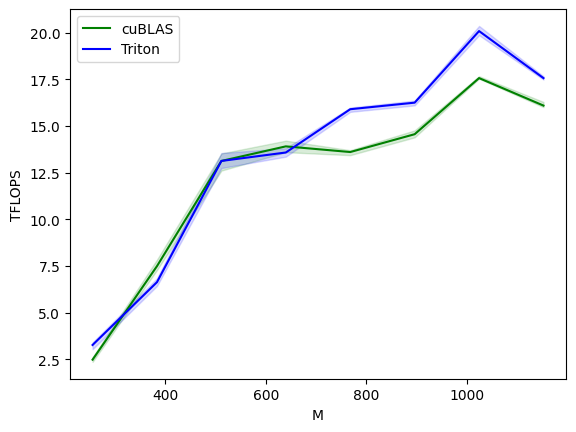

matmul-performance:
        M       N       K     cuBLAS     Triton
0   256.0   256.0   256.0   2.490679   3.276800
1   384.0   384.0   384.0   7.497762   6.639670
2   512.0   512.0   512.0  13.127713  13.127713
3   640.0   640.0   640.0  13.908319  13.579776
4   768.0   768.0   768.0  13.604782  15.896435
5   896.0   896.0   896.0  14.558839  16.247811
6  1024.0  1024.0  1024.0  17.563168  20.080450
7  1152.0  1152.0  1152.0  16.091527  17.561383


In [2]:
import torch

import triton
import triton.language as tl
import triton.profiler as proton
from typing import NamedTuple


def unpack_grid(grid):
  if len(grid) == 1:
    return grid[0], 1, 1
  if len(grid) == 2:
    return grid[0], grid[1], 1
  if len(grid) == 3:
    return grid[0], grid[1], grid[2]


def metadata_fn(
  grid: tuple,
  metadata: NamedTuple,
  args: dict,
):
  grid_x, grid_y, grid_z = unpack_grid(grid)
  num_warps = metadata.num_warps
  num_stages = metadata.num_stages
  cluster_x, cluster_y, cluster_z = metadata.cluster_dims
  shared_memory = metadata.shared
  M, K = args["a_ptr"].shape
  K, N = args["b_ptr"].shape
  return {
    "name":
    f"matmul_<grid:{grid_x}x{grid_y}x{grid_z}>_<cluster:{cluster_x}x{cluster_y}x{cluster_z}>_<warps:{num_warps}>_<shared:{shared_memory}>_<stages:{num_stages}>",
    "flops": 2 * M * N * K,
    "bytes": (M * N + N * K + K * M) * args["a_ptr"].element_size(),
  }


@triton.autotune(
  configs=[
    triton.Config(
      {
        "BLOCK_SIZE_M": 128,
        "BLOCK_SIZE_N": 256,
        "BLOCK_SIZE_K": 64,
        "GROUP_SIZE_M": 8,
      },
      num_stages=3,
      num_warps=8,
    ),
    triton.Config(
      {
        "BLOCK_SIZE_M": 64,
        "BLOCK_SIZE_N": 256,
        "BLOCK_SIZE_K": 32,
        "GROUP_SIZE_M": 8,
      },
      num_stages=4,
      num_warps=4,
    ),
    triton.Config(
      {
        "BLOCK_SIZE_M": 128,
        "BLOCK_SIZE_N": 128,
        "BLOCK_SIZE_K": 32,
        "GROUP_SIZE_M": 8,
      },
      num_stages=4,
      num_warps=4,
    ),
    triton.Config(
      {
        "BLOCK_SIZE_M": 128,
        "BLOCK_SIZE_N": 64,
        "BLOCK_SIZE_K": 32,
        "GROUP_SIZE_M": 8,
      },
      num_stages=4,
      num_warps=4,
    ),
    triton.Config(
      {
        "BLOCK_SIZE_M": 64,
        "BLOCK_SIZE_N": 128,
        "BLOCK_SIZE_K": 32,
        "GROUP_SIZE_M": 8,
      },
      num_stages=4,
      num_warps=4,
    ),
    triton.Config(
      {
        "BLOCK_SIZE_M": 128,
        "BLOCK_SIZE_N": 32,
        "BLOCK_SIZE_K": 32,
        "GROUP_SIZE_M": 8,
      },
      num_stages=4,
      num_warps=4,
    ),
    triton.Config(
      {
        "BLOCK_SIZE_M": 64,
        "BLOCK_SIZE_N": 32,
        "BLOCK_SIZE_K": 32,
        "GROUP_SIZE_M": 8,
      },
      num_stages=5,
      num_warps=2,
    ),
    triton.Config(
      {
        "BLOCK_SIZE_M": 32,
        "BLOCK_SIZE_N": 64,
        "BLOCK_SIZE_K": 32,
        "GROUP_SIZE_M": 8,
      },
      num_stages=5,
      num_warps=2,
    ),
  ],
  key=["M", "N", "K"],
)
@triton.jit(launch_metadata=metadata_fn)
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,  #
    stride_bk, stride_bn,  #
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
    GROUP_SIZE_M: tl.constexpr,  #
    ACTIVATION: tl.constexpr,  #
):
  """Kernel for computing the matmul C = A x B.
  A has shape (M, K), B has shape (K, N) and C has shape (M, N)
  """
  # -----------------------------------------------------------
  # Map program ids `pid` to the block of C it should compute.
  # This is done in a grouped ordering to promote L2 data reuse.
  # See above `L2 Cache Optimizations` section for details.
  pid = tl.program_id(axis=0)
  num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
  num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
  num_pid_in_group = GROUP_SIZE_M * num_pid_n
  group_id = pid // num_pid_in_group
  first_pid_m = group_id * GROUP_SIZE_M
  group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
  pid_m = first_pid_m + (pid % group_size_m)
  pid_n = (pid % num_pid_in_group) // group_size_m

  # ----------------------------------------------------------
  # Create pointers for the first blocks of A and B.
  # We will advance this pointer as we move in the K direction
  # and accumulate
  # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
  # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
  # See above `Pointer Arithmetic` section for details
  offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
  offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
  offs_k = tl.arange(0, BLOCK_SIZE_K)
  a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
  b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

  # -----------------------------------------------------------
  # Iterate to compute a block of the C matrix.
  # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
  # of fp32 values for higher accuracy.
  # `accumulator` will be converted back to fp16 after the loop.
  accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
  for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
    # Load the next block of A and B, generate a mask by checking the K dimension.
    # If it is out of bounds, set it to 0.
    a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
    b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
    # We accumulate along the K dimension.
    accumulator += tl.dot(a, b)
    # Advance the ptrs to the next K block.
    a_ptrs += BLOCK_SIZE_K * stride_ak
    b_ptrs += BLOCK_SIZE_K * stride_bk
  # You can fuse arbitrary activation functions here
  # while the accumulator is still in FP32!
  if ACTIVATION == "leaky_relu":
    accumulator = leaky_relu(accumulator)
  c = accumulator.to(tl.float16)

  # -----------------------------------------------------------
  # Write back the block of the output matrix C with masks.
  offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
  offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
  c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
  c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
  tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
  x = x + 1
  return tl.where(x >= 0, x, 0.01 * x)


def matmul(a, b, activation=""):
  # Check constraints.
  assert a.shape[1] == b.shape[0], "Incompatible dimensions"
  assert a.is_contiguous(), "Matrix A must be contiguous"
  assert b.is_contiguous(), "Matrix B must be contiguous"
  M, K = a.shape
  K, N = b.shape
  # Allocates output.
  c = torch.empty((M, N), device=a.device, dtype=a.dtype)

  # 1D launch kernel where each block gets its own program.
  def grid(META):
    return (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]), )

  matmul_kernel[grid](
    a, b, c,  #
    M, N, K,  #
    a.stride(0), a.stride(1),  #
    b.stride(0), b.stride(1),  #
    c.stride(0), c.stride(1),  #
    ACTIVATION=activation,  #
  )
  return c



@triton.testing.perf_report(
  triton.testing.Benchmark(
    x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
    x_vals=[128 * i for i in range(2, 10)],  # Different possible values for `x_name`
    line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
    # Possible values for `line_arg`
    line_vals=["cublas", "triton"],
    # Label name for the lines
    line_names=["cuBLAS", "Triton"],
    # Line styles
    styles=[("green", "-"), ("blue", "-")],
    ylabel="TFLOPS",  # Label name for the y-axis
    plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
    args={},
  ))
def benchmark(M, N, K, provider):
  a = torch.randn((M, K), device="cuda", dtype=torch.float16)
  b = torch.randn((K, N), device="cuda", dtype=torch.float16)
  quantiles = [0.5, 0.2, 0.8]
  with proton.scope(f"matmul_{M}_{N}_{K}"):
    if provider == "cublas":

      @proton.scope(
        "cublas",
        metrics={
          "flops": 2 * M * N * K,
          "bytes": (M * N + N * K + K * M) * a.element_size(),
        },
      )
      def cublas_matmul(a, b):
        torch.matmul(a, b)

      ms, min_ms, max_ms = triton.testing.do_bench(lambda: cublas_matmul(a, b), quantiles=quantiles)
    if provider == "triton":

      def enter_autotune(args, reset_only=False):
        if reset_only:
          return
        proton.enter_scope("<autotune>")

      def exit_autotune(args, exception):
        proton.exit_scope()

      matmul_kernel.pre_hook = enter_autotune
      matmul_kernel.post_hook = exit_autotune
      with proton.scope("triton"):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)

  def perf(ms):
    return 2 * M * N * K * 1e-12 / (ms * 1e-3)

  return perf(ms), perf(max_ms), perf(min_ms)

proton.start("matmul", hook="triton")
benchmark.run(show_plots=True, print_data=True)
proton.finalize()

In [ ]:
!proton-viewer -m tflop/s -i ".*cublas.*" ./matmul.hatchet

### Demo 9: Triton Hooks

In [3]:
!proton-viewer -m time/ms -i ".*triton.*" ./matmul.hatchet

8619.180 ROOT
├─ 1095.689 matmul_1024_1024_1024
│  └─ 986.756 triton
│     ├─ 91.267 <autotune>
│     │  ├─ 18.500 matmul_<grid:128x1x1>_<cluster:1x1x1>_<warps:4>_<shared:36864>_<stages:4>
│     │  ├─ 14.371 matmul_<grid:256x1x1>_<cluster:1x1x1>_<warps:4>_<shared:30720>_<stages:4>
│     │  ├─ 8.541 matmul_<grid:32x1x1>_<cluster:1x1x1>_<warps:8>_<shared:98304>_<stages:3>
│     │  ├─ 32.412 matmul_<grid:512x1x1>_<cluster:1x1x1>_<warps:2>_<shared:24576>_<stages:5>
│     │  ├─ 8.440 matmul_<grid:64x1x1>_<cluster:1x1x1>_<warps:4>_<shared:49152>_<stages:4>
│     │  └─ 9.003 matmul_<grid:64x1x1>_<cluster:1x1x1>_<warps:4>_<shared:61440>_<stages:4>
│     ├─ 887.167 _ZN2at6native29vectorized_elementwise_kernelILi4ENS0_11FillFunctorIiEENS_6detail5ArrayIPcLi1EEEEEviT0_T1_
│     └─ 8.322 matmul_<grid:64x1x1>_<cluster:1x1x1>_<warps:4>_<shared:49152>_<stages:4>
├─ 1102.237 matmul_1152_1152_1152
│  └─ 993.312 triton
│     ├─ 133.605 <autotune>
│     │  ├─ 27.702 matmul_<grid:162x1x1>_<cluster:1x1x1>_<

### Demo 10: Roofline-based utilization

In [ ]:
!proton-viewer -m util,tflop/s -i ".*triton.*" ./matmul.hatchet

### Demo 11: Instruction sampling

In [ ]:
proton.start("matmul", backend="cupti_pcsampling", hook="triton")

In [ ]:
!proton-viewer -m util,tflop/s -i ".*triton.*" ./matmul.hatchet